# Introduction

In this notebook, we will perform a classification task on the Pima Indians Diabetes dataset using three different machine learning models:
- **Random Forest Classifier**
- **K-Nearest Neighbors (KNN) Classifier**
- **GRU (Gated Recurrent Unit) Neural Network**

We will evaluate the performance of each model using 10-fold cross-validation. We will report the accuracy, precision, recall, and F1-score for each model, as well as visualize confusion matrices.

## Step 1: Import Libraries
First, we need to import all the necessary libraries for this task.

In [37]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Explanation:

    # train_test_split is used to split the dataset into training and testing sets.
    # KFold is used for cross-validation to evaluate the models.
    # We import classifiers from sklearn for Random Forest and KNN.
    # The Sequential model and GRU layers are imported from tensorflow.keras for building the GRU model.
    # matplotlib and seaborn are used for visualization.

## Step 2: Load and Explore the Dataset
Next, let's load the dataset and perform some initial explorations.

In [38]:
# Load the dataset
url = "dataset/pima-indians-diabetes-database.csv"  # Ensure correct path
data = pd.read_csv(url)

# Display dataset information
print(data.head())
print(f'Total number of records: {len(data)}')
print("Columns are: ", data.columns)
data.info()

# Check for missing values
if data.isnull().values.any():
    print("Dataset contains missing values.")
else:
    print("No missing values in the dataset.")

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Total number of records: 768
Columns are:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 colum

## Step 3: Data Preprocessing
We now prepare the data for the models.

In [39]:
# Split data into features (X) and target (Y)
X = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
Y = data['Outcome']

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [40]:
# Function to calculate TP, TN, FP, FN, TSS, HSS
def calculate_metrics(y_true, y_pred):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # True Skill Statistic (TSS)
    TSS = (TP / (TP + FN)) - (FP / (FP + TN))
    
    # Heidke Skill Score (HSS)
    HSS = (TP + TN - (FP + FN)) / (TP + TN + FP + FN)
    
    return TP, TN, FP, FN, TSS, HSS

## Step 4: Define Cross-Validation Function
Here we define a function that performs KFold cross-validation for any given model.

In [41]:
# Function for Cross-Validation and calculating metrics for each model
def cross_val_metrics(model, X, Y):
    # Initialize KFold
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    # Accumulators for metrics
    all_true_labels = []
    all_pred_labels = []

    accuracy, precision, recall, f1 = [], [], [], []
    tss_scores, hss_scores = [], []

    for i, (train_index, test_index) in enumerate(kfold.split(X), start=1):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]
        
        # Train the model
        model.fit(X_train_fold, Y_train_fold)
        
        # Predict and calculate metrics
        Y_pred_fold = model.predict(X_test_fold)
        
        # Append true labels and predictions to accumulators
        all_true_labels.extend(Y_test_fold)
        all_pred_labels.extend(Y_pred_fold)
        
        # Calculate individual fold metrics
        accuracy.append(accuracy_score(Y_test_fold, Y_pred_fold))
        precision.append(precision_score(Y_test_fold, Y_pred_fold))
        recall.append(recall_score(Y_test_fold, Y_pred_fold))
        f1.append(f1_score(Y_test_fold, Y_pred_fold))

        # Calculate TSS and HSS for the fold
        TP, TN, FP, FN, TSS, HSS = calculate_metrics(Y_test_fold, Y_pred_fold)
        tss_scores.append(TSS)
        hss_scores.append(HSS)

    # Calculate confusion matrix once after all folds
    conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

    # Visualize confusion matrix once after all folds
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    # Return average scores
    return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1), np.mean(tss_scores), np.mean(hss_scores)


## Step 5: Train and Evaluate Models
We will now train and evaluate three models: Random Forest, KNN, and GRU.

### Random Forest Model


Performing 10-Fold Cross Validation for Random Forest...


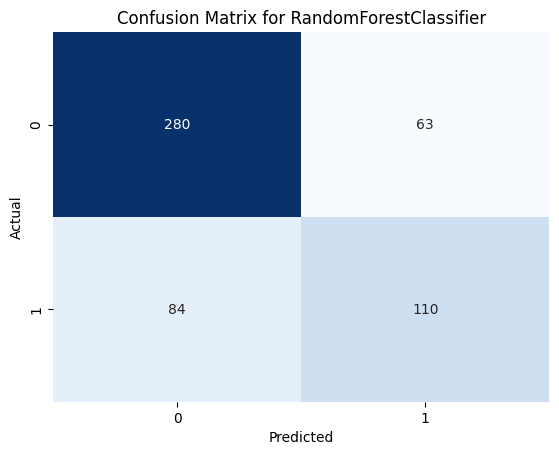

In [42]:
# Random Forest Model
print("\nPerforming 10-Fold Cross Validation for Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
accuracy_rf, precision_rf, recall_rf, f1_rf, tss_rf, hss_rf = cross_val_metrics(rf, X_train, Y_train)

### K-Nearest Neighbors Model


Performing 10-Fold Cross Validation for KNN...


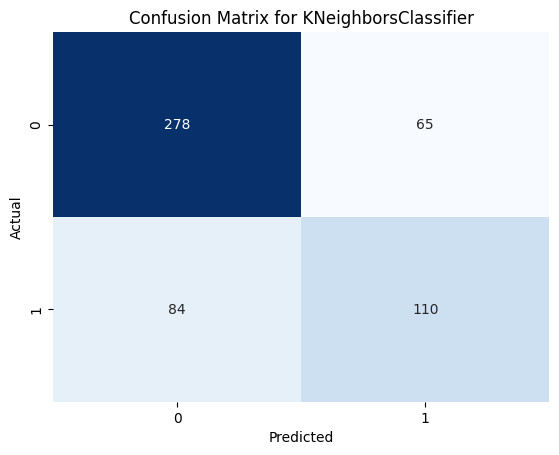

In [43]:
# K-Nearest Neighbors Model
print("\nPerforming 10-Fold Cross Validation for KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
accuracy_knn, precision_knn, recall_knn, f1_knn, tss_knn, hss_knn = cross_val_metrics(knn, X_train, Y_train)

### GRU Model

In [44]:
# GRU Model (For completeness, I'll keep this section)
print("\nPerforming 10-Fold Cross Validation for GRU Model...")
Y_categorical = to_categorical(Y_train, num_classes=2)

X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

kf = KFold(n_splits=10, shuffle=True, random_state=42)
gru_accuracies, gru_precisions, gru_recalls, gru_f1s, gru_tss, gru_hss = [], [], [], [], [], []
all_true_labels_gru = []
all_pred_labels_gru = []

for i, (train_index, test_index) in enumerate(kf.split(X_train_reshaped), start=1):
    X_train_gru, X_test_gru = X_train_reshaped[train_index], X_train_reshaped[test_index]
    Y_train_gru, Y_test_gru = Y_categorical[train_index], Y_categorical[test_index]

    # Build and compile GRU model
    gru_model = Sequential()
    gru_model.add(GRU(16, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]), activation='relu'))
    gru_model.add(Dense(2, activation='softmax'))  # Output layer for binary classification
    gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the GRU model on the training fold
    gru_model.fit(X_train_gru, Y_train_gru, epochs=10, batch_size=32, verbose=0)

    # Predict and calculate metrics
    Y_pred_gru = gru_model.predict(X_test_gru)
    Y_pred_classes_gru = np.argmax(Y_pred_gru, axis=1)
    Y_test_classes_gru = np.argmax(Y_test_gru, axis=1)

    # Append true labels and predictions for GRU
    all_true_labels_gru.extend(Y_test_classes_gru)
    all_pred_labels_gru.extend(Y_pred_classes_gru)

    # Store metrics for GRU
    gru_accuracies.append(accuracy_score(Y_test_classes_gru, Y_pred_classes_gru))
    gru_precisions.append(precision_score(Y_test_classes_gru, Y_pred_classes_gru))
    gru_recalls.append(recall_score(Y_test_classes_gru, Y_pred_classes_gru))
    gru_f1s.append(f1_score(Y_test_classes_gru, Y_pred_classes_gru))

    # Calculate TSS and HSS for GRU
    TP, TN, FP, FN, TSS, HSS = calculate_metrics(Y_test_classes_gru, Y_pred_classes_gru)
    gru_tss.append(TSS)
    gru_hss.append(HSS)

# Average the metrics for GRU
accuracy_gru = np.mean(gru_accuracies)
precision_gru = np.mean(gru_precisions)
recall_gru = np.mean(gru_recalls)
f1_gru = np.mean(gru_f1s)
tss_gru = np.mean(gru_tss)
hss_gru = np.mean(gru_hss)



Performing 10-Fold Cross Validation for GRU Model...


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


C:\Users\Shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step



Confusion Matrix for GRU Model:


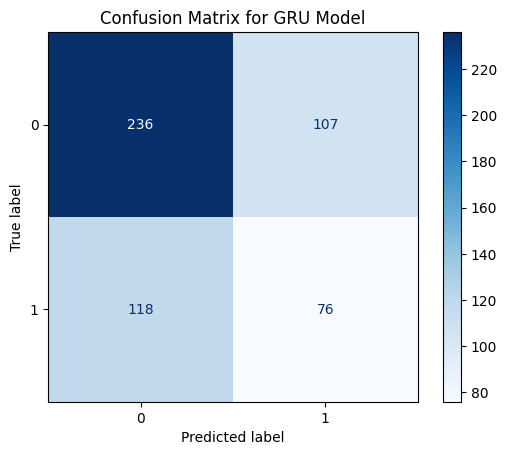

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After the loop where you compute the metrics, add these lines to plot the confusion matrix
print("\nConfusion Matrix for GRU Model:")

# Calculate the confusion matrix
cm_gru = confusion_matrix(all_true_labels_gru, all_pred_labels_gru)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gru)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for GRU Model")
plt.show()

## Step 6: Results and Comparison
We will now display the performance results of all models.

In [46]:
# Model Comparison (Cross-Validation)
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'KNN', 'GRU'],
    'Accuracy': [accuracy_rf, accuracy_knn, accuracy_gru],
    'Precision': [precision_rf, precision_knn, precision_gru],
    'Recall': [recall_rf, recall_knn, recall_gru],
    'F1-Score': [f1_rf, f1_knn, f1_gru],
    'TSS': [tss_rf, tss_knn, tss_gru],
    'HSS': [hss_rf, hss_knn, hss_gru],
})

print("\nModel Comparison (Average Metrics per Model across 10 Folds):")
display(model_comparison)



Model Comparison (Average Metrics per Model across 10 Folds):


,Model,Accuracy,Precision,Recall,F1-Score,TSS,HSS
0,Random Forest,0.726415,0.641096,0.567828,0.598322,0.383459,0.452830
1,KNN,0.722851,0.636645,0.572665,0.596494,0.384371,0.445702
2,GRU,0.581132,0.409342,0.400344,0.399125,0.085502,0.162264


In [47]:
html_table = model_comparison.to_html(index=False)
print(html_table)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Model</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
      <th>TSS</th>
      <th>HSS</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Random Forest</td>
      <td>0.726415</td>
      <td>0.641096</td>
      <td>0.567828</td>
      <td>0.598322</td>
      <td>0.383459</td>
      <td>0.452830</td>
    </tr>
    <tr>
      <td>KNN</td>
      <td>0.722851</td>
      <td>0.636645</td>
      <td>0.572665</td>
      <td>0.596494</td>
      <td>0.384371</td>
      <td>0.445702</td>
    </tr>
    <tr>
      <td>GRU</td>
      <td>0.581132</td>
      <td>0.409342</td>
      <td>0.400344</td>
      <td>0.399125</td>
      <td>0.085502</td>
      <td>0.162264</td>
    </tr>
  </tbody>
</table>


# Discussion of Results
Based on the average metrics from the 10-fold cross-validation, here's a breakdown of the performance for each algorithm:


## Model Comparison (10-Fold Cross Validation):

| Model         | Accuracy | Precision | Recall  | F1-Score | TSS      | HSS      |
|---------------|----------|-----------|---------|----------|----------|----------|
| Random Forest | 0.726415 | 0.641096  | 0.567828| 0.598322 | 0.383459 | 0.452830 |
| KNN           | 0.722851 | 0.636645  | 0.572665| 0.596494 | 0.384371 | 0.445702 |
| GRU           | 0.658840 | 0.536660  | 0.472711| 0.491598 | 0.234726 | 0.317680 |

# Model Performance:

## Random Forest:
- **Accuracy:** 0.7264 (highest among the three models).
- **Precision:** 0.6411 (also the highest), indicating that when the model predicts a positive class (diabetes), it is  more confident in its prediction than KNN and GRU.
- **Recall:** 0.5678, showing that the model correctly identifies a good portion of the actual positives, although still missing some.
- **F1-Score:** 0.5983, a balance between precision and recall, indicating decent performance on the imbalanced dataset.
- **TSS and HSS:** These values are also higher compared to KNN and GRU, suggesting the Random Forest is better at distinguishing between positive and negative cases and overall better predictive performance.

## Which algorithm performs better and why?
Random Forest performs the best overall because:
1. Better Accuracy
2. Higher Precision and Recall
3. Balance between Precision and Recall
4. Higher TSS and HSS

## Why did GRU perform poorly?
The GRU model is a powerful tool for sequential data, but it seems to be underperforming because: 
- **Inappropriate Model Choice**
    - The GRU is designed for time-series or sequential data, and may not be the ideal choice for this tabular dataset.
- **Feature Representation**
    - The dataset is tabular, and deep learning models like GRU may not perform well unless properly preprocessed or tuned for tabular data.

# Conclusion:
The more effective model for this issue is **Random Forest**. Its improved accuracy and classification metrics performance is probably due to its ensemble nature and capacity to handle skewed datasets. KNN performs well as well, yielding results that are comparable to Random Forest's. However, Random Forest beats it on the majority of measures. The GRU model is not a good fit for this tabular dataset without significant adjustments or enhancements, even though it excels at sequential tasks.